# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [50]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_diaria_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-25 00:00:00 a 2025-12-03 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,136.88,2022-07-25,136.88
1,1,234.00,2022-07-27,234.00
2,1,391.00,2022-07-27,391.00
3,3,354.00,2022-07-28,354.00
4,1,521.00,2022-07-28,521.00


In [51]:
df_main = df_main[df_main['fecha'] <= '2024-12-31']

Filtro para obtener muestra de datos

In [52]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [53]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.1,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=20.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=20.0)
m.fit(df)


09:28:56 - cmdstanpy - INFO - Chain [1] start processing
09:28:57 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [54]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1244 2025-12-27
1245 2025-12-28
1246 2025-12-29
1247 2025-12-30
1248 2025-12-31


Paso 5: Realizar la Predicción (Forecast)

In [55]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds          yhat    yhat_lower    yhat_upper
1244 2025-12-27  16821.196846  -5215.114796  39786.604796
1245 2025-12-28  19672.557243  -2311.740625  43194.754428
1246 2025-12-29  11971.016474 -11561.703813  35675.377945
1247 2025-12-30  11660.558341 -11714.821910  35366.381018
1248 2025-12-31  11279.080437 -12406.043031  32869.966649


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

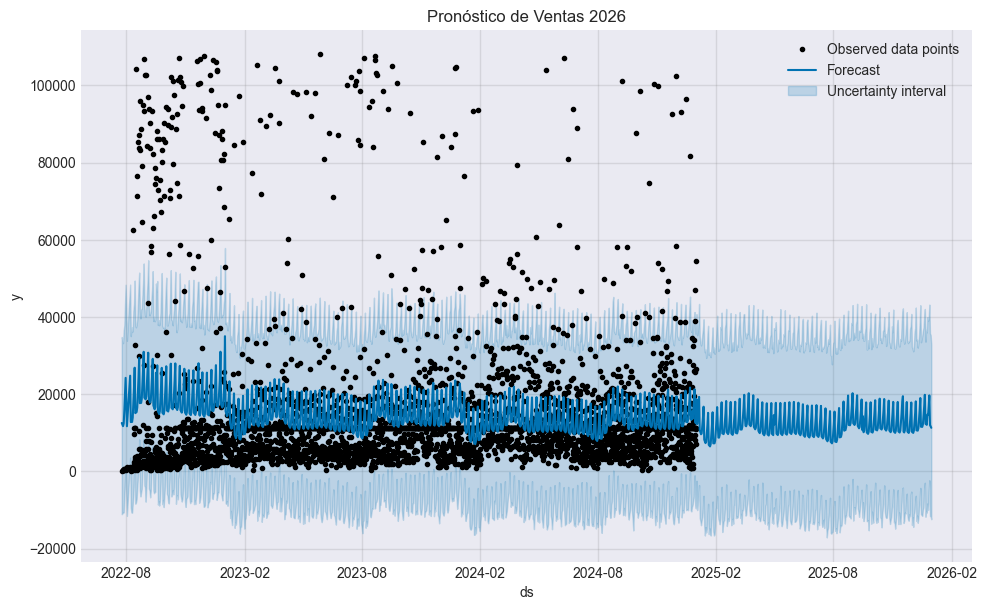

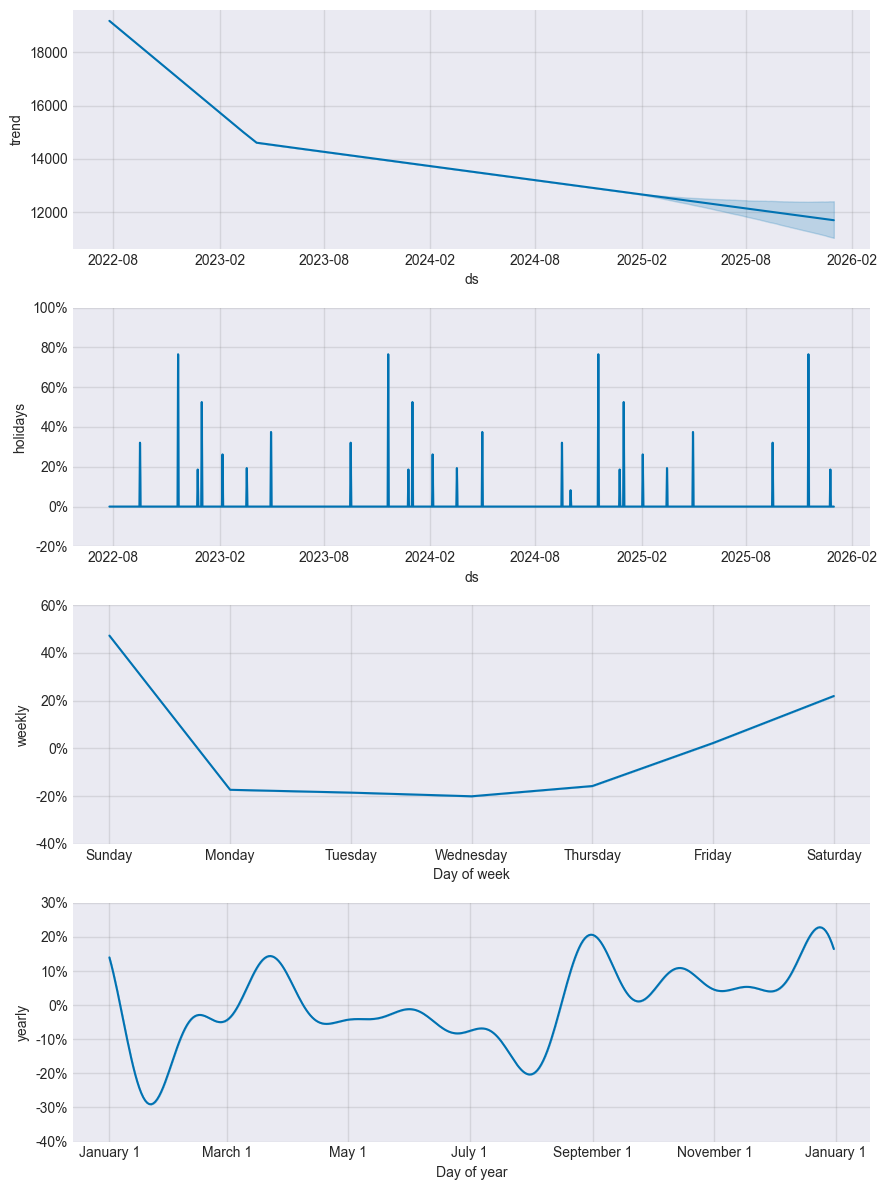

In [56]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

In [57]:
sales = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

##### Agrupamos data por mes para su exportacion

In [58]:
sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_general_monthly.csv")

In [59]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/1 [00:00<?, ?it/s]

09:28:59 - cmdstanpy - INFO - Chain [1] start processing
09:28:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


  horizon          rmse      mape
0  9 days  14469.802311  2.695090
1 10 days  14798.355873  2.907150
2 11 days  15462.301735  3.123236
3 12 days  15360.170116  3.324444
4 13 days   9477.235326  3.284862


Suma de totales por cada proyeccion

In [60]:
# sumar por columna sales 'yhat', 'yhat_lower', 'yhat_upper'
sales_sum = sales[['yhat', 'yhat_lower', 'yhat_upper']].sum()
sales_sum.round(2)


yhat          17624665.77
yhat_lower   -11007551.60
yhat_upper    46211613.76
dtype: float64